# Homework 1: Multi-Task Learning with a Two-Headed MLP

In this notebook, we implement a multi-task learning model using a two-headed MLP.  
The model predicts:

1. **Student's final grade (G3)** — regression task  
2. **Student's romantic status** — classification task ('yes' or 'no')  

We preprocess the UCI Student Performance dataset (specifically student-por.csv), train a shared MLP body with two heads, and evaluate the model on both tasks using appropriate metrics (MAE, Accuracy, F1-Score).  
We also experiment with **weighted losses** to balance the regression and classification objectives.

In [111]:
# Imports necessary for model training and evaluation
import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
import torch
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, f1_score, mean_absolute_error
import torch.nn as nn
import torch.optim as optim
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt

# Relative file path to desired dataset
CVS_PATH = 'student/student-por.csv'

# Reproducibility
torch.manual_seed(42)
np.random.seed(42)

## Data Preprocessing Setup

Before feeding data into the neural network, we need to distinguish between **categorical** and **numerical** features:

- **Categorical (nominal) features**: These include binary or multi-class columns like `sex`, `school`, `Mjob`, etc.  
  We will convert them into **one-hot encoded vectors** so that the network can process them as numerical inputs.

- **Numerical features**: Columns like `age`, `G1`, `G2`, etc. will be **normalized** using `StandardScaler`.  
  Normalization ensures that all numeric inputs are on a similar scale, which improves training stability and convergence.

In [112]:
# These are nominal columns that will be transformed into one-hot vectors
COLUMNS_TO_CATEGORIZE = ['school', 'sex', 'address', 'famsize', 'Pstatus', 'Mjob', 'Fjob', 'reason', 'guardian', 'schoolsup', 'famsup', 'paid',
                         'activities', 'nursery', 'higher', 'internet', 'romantic']

# These are nominal columns that will be scaled
COLUMNS_TO_NORMALIZE = ['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences', 'G1', 'G2'] 

## Load and Preprocess Data

In this step, we will:

1. **Load the CSV dataset** into a pandas DataFrame.  
2. **Apply one-hot encoding** to the categorical columns defined earlier.  
3. **Normalize numerical columns** using `StandardScaler` to ensure all numeric features are on a similar scale.  

After preprocessing, the data will be ready to split into inputs (`X`) and targets (`y_grade` and `y_romantic`) for training the multi-task model.

In [113]:
# Loading data from file
df = pd.read_csv(CVS_PATH, delimiter=';')

# This does one-hot encoding (for each column each category we will have column (e.g. sex_M, sex_F) that has either 0 or 1 value)
df = pd.get_dummies(
    df, 
    columns=COLUMNS_TO_CATEGORIZE,
    prefix=COLUMNS_TO_CATEGORIZE
).astype(int)

# We use StandardScaler here, nothing special
scaler = StandardScaler()
df[COLUMNS_TO_NORMALIZE] = scaler.fit_transform(df[COLUMNS_TO_NORMALIZE])

Separate the features and targets:  
- `X` contains all input features.  
- `y_grade` is the regression target (final grade G3).  
- `y_romantic` is the classification target (romantic status, 0/1).

In [ ]:

X = df.drop(columns=['G3', 'romantic_yes', 'romantic_no']).values.astype(np.float32)
y_grade = df['G3'].values.astype(np.float32).reshape(-1, 1)   # type: ignore
y_romantic = df['romantic_yes'].values.astype(int)

Split the data into **train, validation, and test sets**:  
- The first split separates out the test set (15% of the data).  
- The second split divides the remaining data into training and validation sets (≈75% train, ≈15% validation).  
This ensures we can train the model, validate during training, and evaluate on a held-out test set.

In [115]:
X_trainval, X_test, y_grade_trainval, y_grade_test, y_rom_trainval, y_rom_test = train_test_split(
    X, y_grade, y_romantic, test_size=0.15, random_state=42
)
X_train, X_val, y_grade_train, y_grade_val, y_rom_train, y_rom_val = train_test_split(
    X_trainval, y_grade_trainval, y_rom_trainval, test_size=0.15, random_state=42
)

Create a **custom PyTorch Dataset** to handle our multi-task data:  

- Returns a tuple `(x_data, y_grade, y_romantic)` for each sample.  
- Ensures features are `float32` and targets are the correct types (`float32` for regression, `long` for classification).  
- Works seamlessly with a `DataLoader` for batching.

In [116]:

class StudentDatasetPor(Dataset):
    def __init__(self, X, y_grade, y_romantic):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y_grade = torch.tensor(y_grade, dtype=torch.float32)
        self.y_romantic = torch.tensor(y_romantic, dtype=torch.long)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y_grade[idx], self.y_romantic[idx]

Instantiate the **train, validation, and test datasets** using our custom `StudentDatasetPor` class.  
These datasets will later be fed into `DataLoader`s for batching during training and evaluation.

In [117]:
train_dataset = StudentDatasetPor(X_train, y_grade_train, y_rom_train)
val_dataset = StudentDatasetPor(X_val, y_grade_val, y_rom_val)
test_dataset = StudentDatasetPor(X_test, y_grade_test, y_rom_test)

Define **training hyperparameters** and **network layer sizes**:  

- `BATCH_SIZE`: Number of samples per batch  
- `FIRST_NEURON_N`, `SECOND_NEURON_N`, `THIRD_NEURON_N`: Sizes of hidden layers in the shared MLP body  
- `LEARNING_RATE`: Learning rate for the optimizer  
- `EPOCHS`: Number of training iterations over the full dataset

In [118]:
BATCH_SIZE = 16
FIRST_NEURON_N = 16
SECOND_NEURON_N = 8
LEARNING_RATE = 1e-3
EPOCHS = 50

Create **DataLoaders** to efficiently feed data into the model:  

- `train_loader` shuffles the training data each epoch for better generalization.  
- `val_loader` and `test_loader` do not shuffle, ensuring consistent evaluation.  
- `BATCH_SIZE` controls how many samples are processed in each iteration.

In [119]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

Define the **Multi-Task Neural Network Architecture**:

- The model consists of a **shared MLP body** that learns a common representation of the student profile.
- Two separate **task-specific heads** are built on top of the shared features:
  - **Grade Head (Regression):** Outputs a single value for the predicted final grade.
  - **Romantic Head (Classification):** Outputs logits for the two classes (yes / no).
- The grade output is scaled to the range **[0, 20]** using a `sigmoid` activation.
- Batch Normalization and Dropout are used for **training stability and regularization**.

In [120]:
class StudentMLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        
        self.shared = nn.Sequential(
            nn.Linear(input_dim, FIRST_NEURON_N),
            nn.BatchNorm1d(FIRST_NEURON_N),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(FIRST_NEURON_N, SECOND_NEURON_N),
            nn.BatchNorm1d(SECOND_NEURON_N),
            nn.ReLU(),
            nn.Dropout(0.2)
        )
        
        self.grade_head = nn.Linear(SECOND_NEURON_N, 1)
        
        self.romantic_head = nn.Linear(SECOND_NEURON_N, 2)

    def forward(self, x):
        features = self.shared(x)

        grade_pred = torch.sigmoid(self.grade_head(features)) * 20
        romantic_logit = self.romantic_head(features)

        return grade_pred, romantic_logit

Set up the **training environment**:

- Select the computation device (GPU if available, otherwise CPU).
- Initialize the multi-task model and move it to the chosen device.
- Define the two loss functions:
  - `MSELoss` for grade prediction (regression)
  - `CrossEntropyLoss` for romantic status prediction (classification)
- Initialize the optimizer (`Adam`) with the chosen learning rate.

In [121]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = StudentMLP(X.shape[1]).to(device)

criterion_grade = nn.MSELoss()               

y_rom_train_np = y_rom_train.numpy() if isinstance(y_rom_train, torch.Tensor) else y_rom_train

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.array([0, 1]),
    y=y_rom_train_np
)

class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

criterion_romantic = nn.CrossEntropyLoss(weight=class_weights)

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)


Initialize lists to **store training and validation losses** for later visualization:

- Total loss
- Grade (regression) loss
- Romantic (classification) loss

These will be used to plot learning curves after training.

In [122]:
train_losses = []
val_losses = []
train_grade_losses = []
val_grade_losses = []
train_romantic_losses = []
val_romantic_losses = []

Define a helper function to compute the **weighted total loss** using a mixing coefficient `alpha`:

- `alpha` controls the importance of the **grade regression loss**
- `(1 - alpha)` controls the importance of the **romantic classification loss**

This allows flexible balancing between the two tasks.

In [123]:
def calculate_loss_alpha(loss_grade, loss_romantic, alpha):
    return loss_grade*alpha + (1-alpha)*loss_romantic

Train and validate the **multi-task model** for one full training cycle over `EPOCHS`.

At each epoch:
- The model is trained on the **training set**
- Then evaluated on the **validation set**
- Both **grade regression loss** and **romantic classification loss** are tracked
- A combined loss is computed using `alpha`:
  - If `alpha = None`, losses are simply summed
  - Otherwise, a weighted combination is used

All losses are stored for later visualization.

In [124]:
def train_val_model(alpha = None): 
    for epoch in range(EPOCHS):
        model.train()
        total_train_loss = 0
        total_train_grade_loss = 0
        total_train_romantic_loss = 0

        for x_batch, y_grade_batch, y_romantic_batch in train_loader:
            x_batch = x_batch.to(device)
            y_grade_batch = y_grade_batch.to(device)
            y_romantic_batch = y_romantic_batch.to(device)

            optimizer.zero_grad()

            grade_pred, romantic_logits = model(x_batch)

            loss_grade = criterion_grade(grade_pred, y_grade_batch)
            loss_romantic = criterion_romantic(romantic_logits, y_romantic_batch)

            if alpha is None:
                loss = loss_grade + loss_romantic
            else:
                loss = calculate_loss_alpha(loss_grade=loss_grade, loss_romantic=loss_romantic, alpha=alpha)
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item() * x_batch.size(0)
            total_train_grade_loss += loss_grade.item() * x_batch.size(0)
            total_train_romantic_loss += loss_romantic.item() * x_batch.size(0)

        total_train_loss /= len(train_loader.dataset) # type: ignore
        total_train_grade_loss /= len(train_loader.dataset) # type: ignore
        total_train_romantic_loss /= len(train_loader.dataset) # type: ignore
        train_losses.append(total_train_loss)
        train_grade_losses.append(total_train_grade_loss)
        train_romantic_losses.append(total_train_romantic_loss)

        # =======================
        # VALIDATION
        # =======================
        model.eval()
        total_val_loss = 0
        total_val_grade_loss = 0
        total_val_romantic_loss = 0

        with torch.no_grad():
            for x_batch, y_grade_batch, y_romantic_batch in val_loader:
                x_batch = x_batch.to(device)
                y_grade_batch = y_grade_batch.to(device)
                y_romantic_batch = y_romantic_batch.to(device)

                grade_pred, romantic_logits = model(x_batch)

                loss_grade = criterion_grade(grade_pred, y_grade_batch)
                loss_romantic = criterion_romantic(romantic_logits, y_romantic_batch)

                if alpha is None:
                    loss_val = loss_grade + loss_romantic
                else:
                    loss_val = calculate_loss_alpha(loss_grade, loss_romantic, alpha)

                total_val_loss += loss_val.item() * x_batch.size(0)
                total_val_grade_loss += loss_grade.item() * x_batch.size(0)
                total_val_romantic_loss += loss_romantic.item() * x_batch.size(0)

        total_val_loss /= len(val_loader.dataset) # type: ignore
        total_val_grade_loss /= len(val_loader.dataset) # type: ignore
        total_val_romantic_loss /= len(val_loader.dataset) # type: ignore
        val_losses.append(total_val_loss)
        val_grade_losses.append(total_val_grade_loss)
        val_romantic_losses.append(total_val_romantic_loss)

        # print(
        #     f"Epoch [{epoch+1}/{EPOCHS}] | "
        #     f"Train Loss: {total_train_loss:.4f} | "
        #     f"Val Loss: {total_val_loss:.4f}"
        # )

Evaluate the trained model on the **test set** using task-specific metrics:

- **MAE** for grade regression
- **Accuracy** for romantic relationship classification
- **F1-score (Yes class)** to measure positive class quality

Predictions are collected batch-by-batch with `torch.no_grad()` to disable gradient tracking.

In [125]:
def evaluate_test(model, test_loader, device):
    model.eval()

    all_grade_preds = []
    all_grade_true = []

    all_romantic_preds = []
    all_romantic_true = []

    with torch.no_grad():
        for x_batch, y_grade_batch, y_romantic_batch in test_loader:
            x_batch = x_batch.to(device)
            y_grade_batch = y_grade_batch.to(device)
            y_romantic_batch = y_romantic_batch.to(device)

            grade_out, romantic_out = model(x_batch)

            all_grade_preds.extend(grade_out.cpu().numpy().flatten())
            all_grade_true.extend(y_grade_batch.cpu().numpy().flatten())

            romantic_pred_labels = romantic_out.argmax(dim=1)
            all_romantic_preds.extend(romantic_pred_labels.cpu().numpy())
            all_romantic_true.extend(y_romantic_batch.cpu().numpy())


    mae = mean_absolute_error(all_grade_true, all_grade_preds)

    accuracy = accuracy_score(all_romantic_true, all_romantic_preds)

    f1_yes = f1_score(all_romantic_true, all_romantic_preds, pos_label=1)

    return {
        "grade_MAE": mae,
        "romantic_accuracy": accuracy,
        "romantic_f1_yes": f1_yes
    }



This is **experiment** function that you can use to test model with different alphas (or without even alpha):

- Resets **model and optimizer**
- Resets all **history**
- Trains model with given **alpha**
- Tests **trained model** on test data loader and prints results
- Saves model if you give **save_name**
- Plots all history of **losses**

You can use this function under the block where function is defined.

In [126]:
def run_experiment(alpha=None, save_name=None):
    global model, optimizer
    
    # ============================
    # 1. RESET MODEL + OPTIMIZER
    # ============================
    model = StudentMLP(X.shape[1]).to(device)
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    # ============================
    # 2. RESET ALL HISTORY
    # ============================
    train_losses.clear()
    val_losses.clear()
    train_grade_losses.clear()
    val_grade_losses.clear()
    train_romantic_losses.clear()
    val_romantic_losses.clear()

    # ============================
    # 3. TRAIN + VALIDATE
    # ============================
    train_val_model(alpha)

    # ============================
    # 4. TEST EVALUATION
    # ============================
    results = evaluate_test(model, test_loader, device)

    print("\n===== TEST RESULTS =====")
    print(f"Grade MAE          : {results['grade_MAE']:.4f}")
    print(f"Romantic Accuracy  : {results['romantic_accuracy']:.4f}")
    print(f"Romantic F1 (Yes) : {results['romantic_f1_yes']:.4f}")

    # ============================
    # 5. SAVE MODEL (OPTIONAL)
    # ============================
    if save_name:
        torch.save(model.state_dict(), save_name)
        print(f"\nModel saved as: {save_name}")

    # ============================
    # 6. PLOTTING
    # ============================
    epochs_range = range(1, EPOCHS + 1)

    plt.figure()
    plt.plot(epochs_range, train_losses, label="Train Total Loss")
    plt.plot(epochs_range, val_losses, label="Val Total Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Total Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure()
    plt.plot(epochs_range, train_grade_losses, label="Train Grade Loss")
    plt.plot(epochs_range, val_grade_losses, label="Val Grade Loss")
    plt.xlabel("Epoch")
    plt.ylabel("MSE")
    plt.title("Grade Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure()
    plt.plot(epochs_range, train_romantic_losses, label="Train Romantic Loss")
    plt.plot(epochs_range, val_romantic_losses, label="Val Romantic Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Cross-Entropy")
    plt.title("Romantic Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

    return results

## Basic Model's Results
===== TEST RESULTS =====
- Grade MAE          : 0.8422
- Romantic Accuracy  : 0.5204
- Romantic F1 (Yes) : 0.3188

Test Here:


===== TEST RESULTS =====
Grade MAE          : 1.0467
Romantic Accuracy  : 0.5204
Romantic F1 (Yes) : 0.3380

Model saved as: basic_model.pth


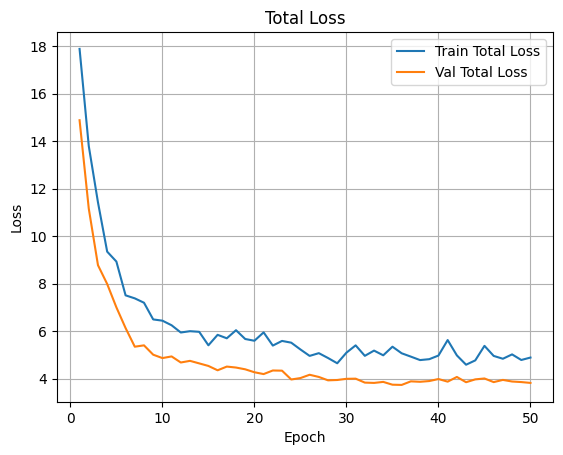

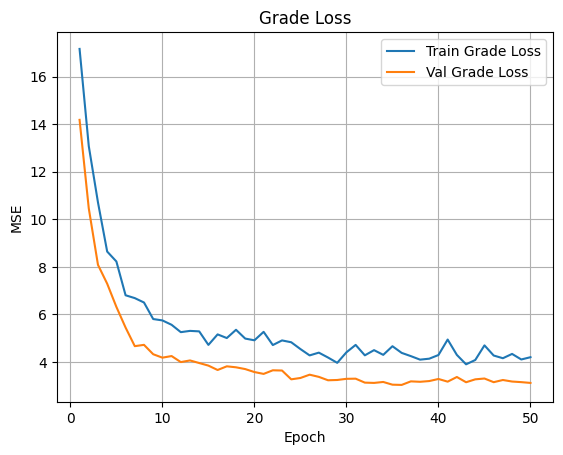

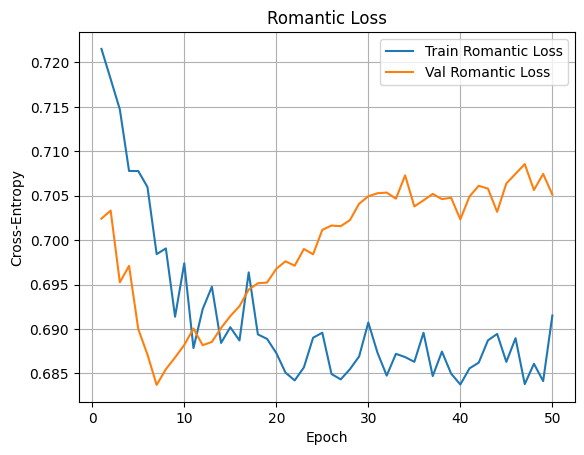

{'grade_MAE': 1.0466578250028649,
 'romantic_accuracy': 0.5204081632653061,
 'romantic_f1_yes': 0.3380281690140845}

In [127]:
# For example (alpha = None, total_loss = loss_grade + loss_romantic)
run_experiment(save_name='basic_model.pth')


===== TEST RESULTS =====
Grade MAE          : 1.1262
Romantic Accuracy  : 0.5714
Romantic F1 (Yes) : 0.4324

Model saved as: large_alpha_model.pth


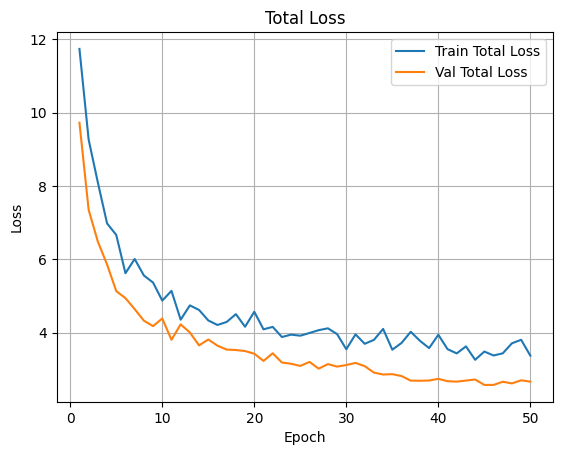

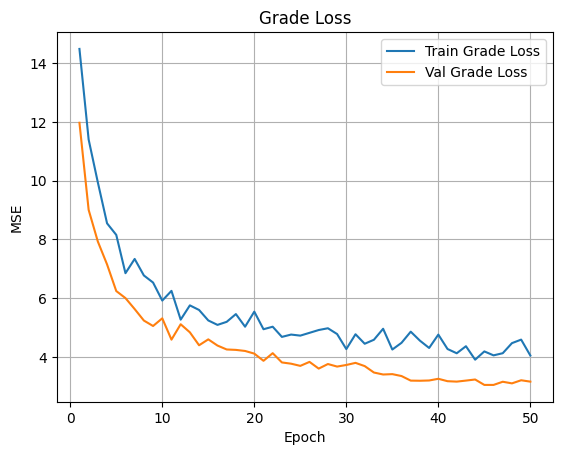

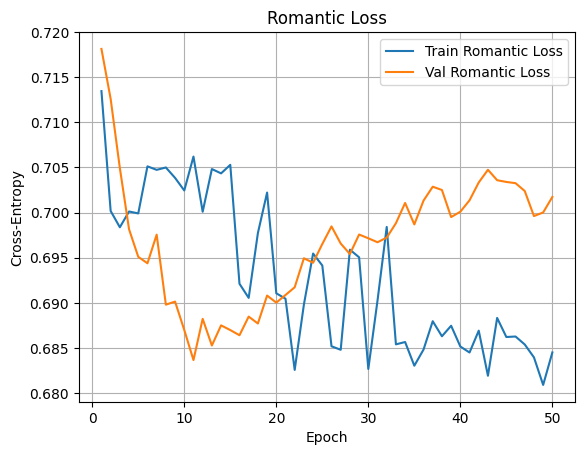

In [128]:
results_large = run_experiment(alpha=0.8, save_name="large_alpha_model.pth")


===== TEST RESULTS =====
Grade MAE          : 0.9656
Romantic Accuracy  : 0.5918
Romantic F1 (Yes) : 0.3103

Model saved as: medium_alpha_model.pth


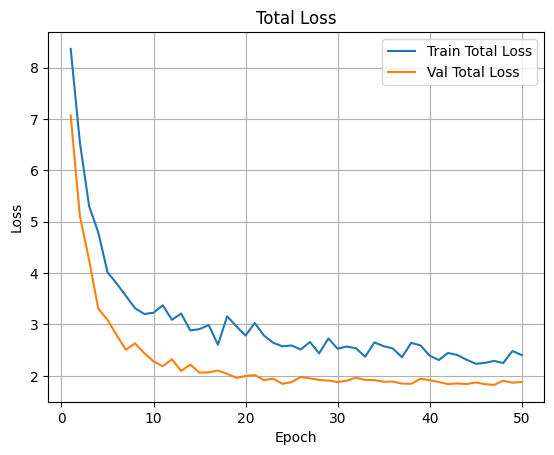

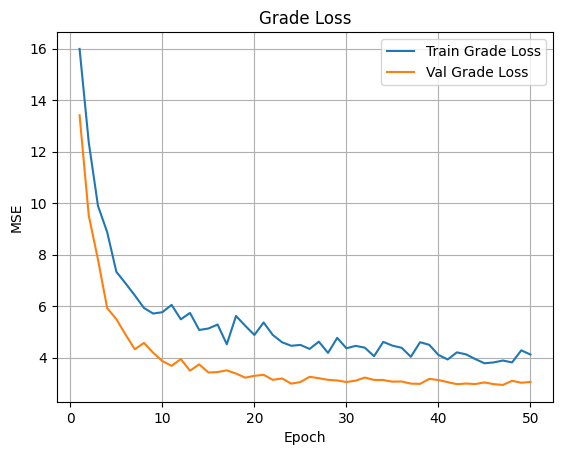

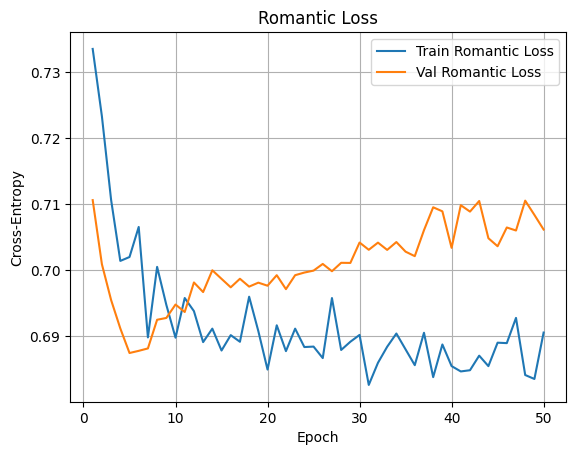

In [129]:
results_medium = run_experiment(alpha=0.5, save_name="medium_alpha_model.pth")


===== TEST RESULTS =====
Grade MAE          : 1.1364
Romantic Accuracy  : 0.5918
Romantic F1 (Yes) : 0.3548

Model saved as: small_alpha_model.pth


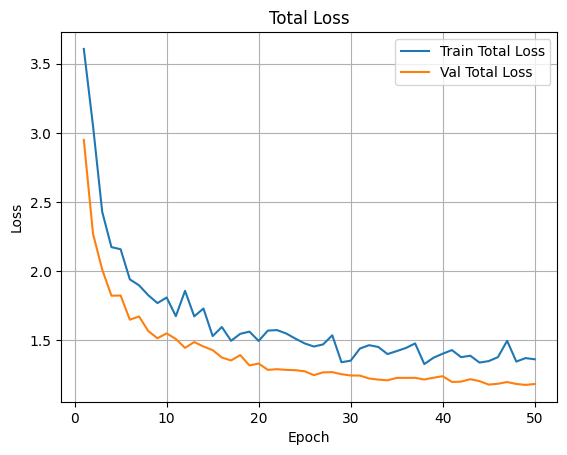

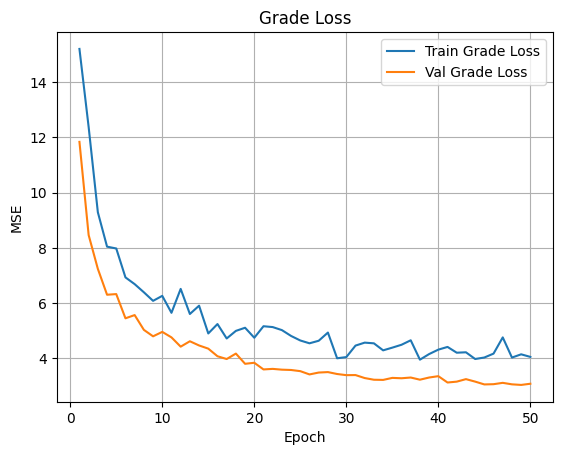

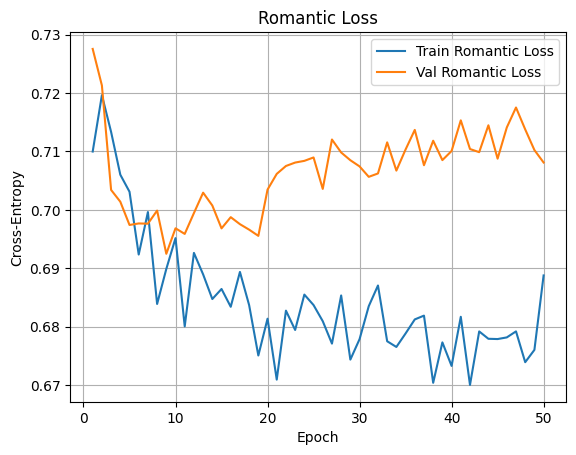

In [130]:
results_small = run_experiment(alpha=0.2, save_name='small_alpha_model.pth')


===== TEST RESULTS =====
Grade MAE          : 1.4679
Romantic Accuracy  : 0.5714
Romantic F1 (Yes) : 0.4474

Model saved as: extra_small_alpha_model.pth


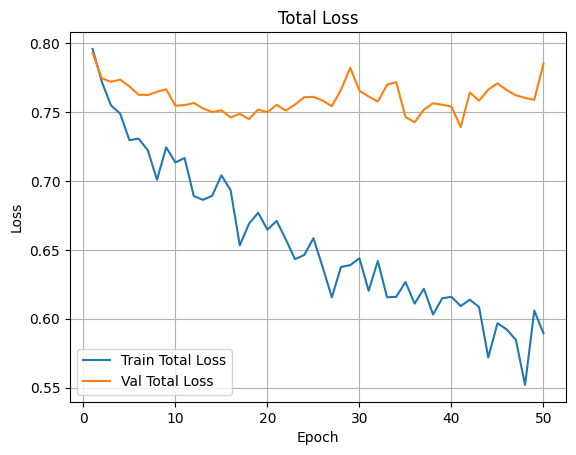

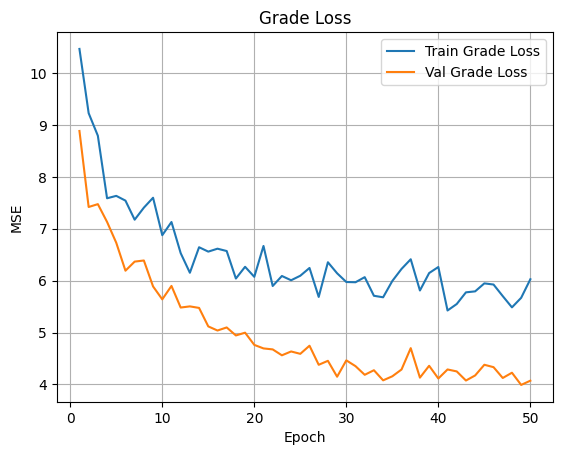

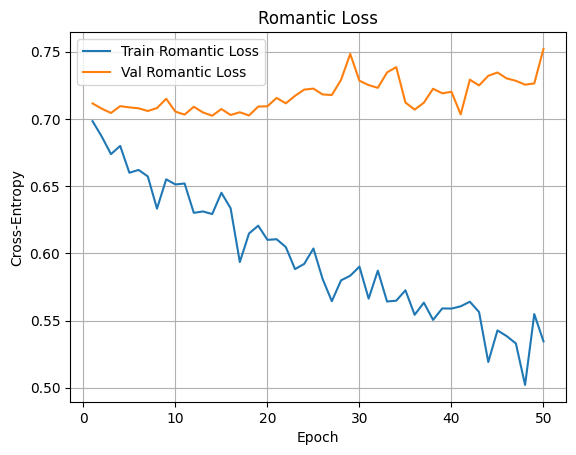

In [131]:
results_extra_small = run_experiment(alpha=0.01, save_name='extra_small_alpha_model.pth')

### Bonus Task Table

In [132]:
results_dict = {
    0.01: results_extra_small,
    0.2: results_small,
    0.5: results_medium,
    0.8: results_large
}


table = pd.DataFrame({
    'Alpha': list(results_dict.keys()),
    'Grade MAE': [res['grade_MAE'] for res in results_dict.values()],
    'Romantic Accuracy': [res['romantic_accuracy'] for res in results_dict.values()],
    'Romantic F1 (Yes)': [res['romantic_f1_yes'] for res in results_dict.values()]
})

table = table.sort_values('Alpha').reset_index(drop=True)

print(table)

   Alpha  Grade MAE  Romantic Accuracy  Romantic F1 (Yes)
0   0.01   1.467885           0.571429           0.447368
1   0.20   1.136435           0.591837           0.354839
2   0.50   0.965631           0.591837           0.310345
3   0.80   1.126169           0.571429           0.432432
